# SMYLE: Nino3.4 Check 
 - Check that Nino3.4 prediction looks reasonable at early lead times
 - data I/O functions based on template from daniel kennedy (djk2120@ucar.edu): https://github.com/djk2120/cesm-lens

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [2]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
#cluster.close()
#client.close()

In [3]:
# ONLY RUN THIS CELL ONCE  
# NOTE: you may need to change the project number
proj = 'NCGD0011'
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from ncar_jobqueue import NCARCluster 
from dask.distributed import Client
cluster = NCARCluster(cores=ncores,
                     death_timout=60, 
                     processes=ncores, memory=nmem,
                     project=proj,
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [4]:
cluster

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are currently hard-wired to retrieve ocean monthly data

In [5]:
def file_dict(topdir,field,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    #build casename
    casebase = 'b.e21.BSMYLE.f09_g17.'
    ocn_monthly = 'ocn/proc/tseries/month_1/'
    casename = casebase+'????-'+monstr+'.'+memstr
    filetemp = topdir+casename+'/'+ocn_monthly+casename+'.pop.h.'+field+'.*.nc'
    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split(casebase)[-1]
        y0 = int(ystr[0:4])
        filepaths[y0]=file
        
    return filepaths

In [6]:
# Test how it works:
#filepaths = file_dict('/glade/campaign/cesm/development/espwg/SMYLE/archive/','SSH',1,11)
#filepaths

In [7]:
def nested_file_list_by_member(datadir,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                filepaths = file_dict(datadir,field,ee,stmon)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [8]:
# Test how it works
#files,ens = nested_file_list_by_member('/glade/campaign/cesm/development/espwg/SMYLE/archive/',range(10),'SSH',1958,1997,11)
#files[9]
#ens

In [9]:
def nested_file_list_by_year(datadir,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(datadir,field,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [10]:
# Test how it works
#files,yrs = nested_file_list_by_year('/glade/campaign/cesm/development/espwg/SMYLE/archive/',range(10),'SSH',1958,1997,11)
#files[0]
#yrs

In [11]:
def get_monthly_data(datadir,ens,field,firstyear,lastyear,stmon):
    ''' returns an xarray dataset containing the requested ensemble
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    firstyear = int [1850-1950]
    lastyear  = int [1850-1950] '''

    ds = xr.Dataset()    #instantiate Dataset
    lm = np.arange(1,25) # hard-wired for 24-month leads
    files,yrs = nested_file_list_by_year(datadir,ens,field,firstyear,lastyear,stmon)
    ens = np.array(range(10))+1
#    ensdim  = xr.DataArray(ens, dims='M', name='member')
#    yeardim = xr.DataArray(yrs, dims='Y', name='startyear')
#    leaddim = xr.DataArray(lm, dims='LM', name='leadmonth')
#    dims    = [yeardim,ensdim,leaddim,None,None]
    
    # all members should have the same number of files, otherwise abort
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        complete_set=True   # same number of files
    else:
        raise ValueError('ERROR: Incomplete set of files')
        
    if complete_set: #read all data in one go
        dsets = []
        for ffs in files:
            d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,concat_dim='M',data_vars=[field])
            # quick fix to adjust time vector for monthly data  
            nmonths = len(d0.time)
            yr0 = d0['time.year'][0].values
            d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
            d0 = d0.assign_coords(M=("M",ens))
            d0 = d0.assign_coords(L=("time",lm))
            d0 = d0.swap_dims({'time': 'L'})
            d0 = d0.reset_coords(["time"])
            dsets.append(d0)
        tmp = xr.concat(dsets,dim='Y',data_vars=[field,'time','time_bound'])
        tmp = tmp.assign_coords(Y=("Y",yrs))
    ds[field] = tmp[field]
    ds['time'] = tmp['time']
    ds['time_bound'] = tmp['time_bound']
    ds['TAREA'] = tmp['TAREA']
    ds['UAREA'] = tmp['UAREA']

    #grab one copy of the various extra variables, e.g. landfrac,area
#    tmp = xr.open_dataset(files[0][0])
#    for thisvar in tmp.data_vars:
#        if 'time' not in tmp[thisvar].coords:
#            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
#    nmonths = len(ds.time)
#    yr0 = ds['time.year'][0].values
#    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds

# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [13]:
%%time
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
ens = range(10)
firstyear = 1958
lastyear  = 1997
ds_temp = get_monthly_data(datadir,ens,'TEMP',firstyear,lastyear,11)
ds_temp.nbytes/1e9 #GB

CPU times: user 5min 21s, sys: 42 s, total: 6min 3s
Wall time: 14min 44s


283.121442112

### Examine Nino3.4 SST

In [15]:
# Compute masks & weights for Nino3.4 regional average
tlat = ds_temp.TLAT
tlon = xr.where(ds_temp.TLONG>180.,ds_temp.TLONG-360.,ds_temp.TLONG)

# Nino3.4
y0a = -5.
y1a =  5.
x0a = -170.
x1a = -120.
region1 = (tlat>=y0a) & (tlat<=y1a) & (tlon>=x0a) & (tlon<=x1a)
areawgt1 = xr.where(region1, ds_temp.TAREA.fillna(0),0)

- Here, perform actual computation, returning xarray

In [16]:
smyle_nino34 = ds_temp.TEMP.isel(z_t=0).weighted(areawgt1).mean(("nlon", "nlat")).load()
time_bound = ds_temp.time_bound.load()

In [19]:
# Get NOAA ERSSTv5 Nino3.4 Obs
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/SST/NOAA_ERSSTv5/ersst.v5.188001-201712.gx1v6.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(138) for month in range(12)]
ds_obs['time'] = obs_time_vals
obs_nino34 = ds_obs.sst.weighted(areawgt1).mean(("nlon", "nlat"))

### Generate Plot
- For some reason, I can't get `errorbar` or `scatter` plot methods to handle the cftime.DatetimeNoLeap time values. `plot` can handle it. 
The error message reports it needs cftime.datetime objects, but isinstance(smyletime.values[0],cftime.datetime) returns True.

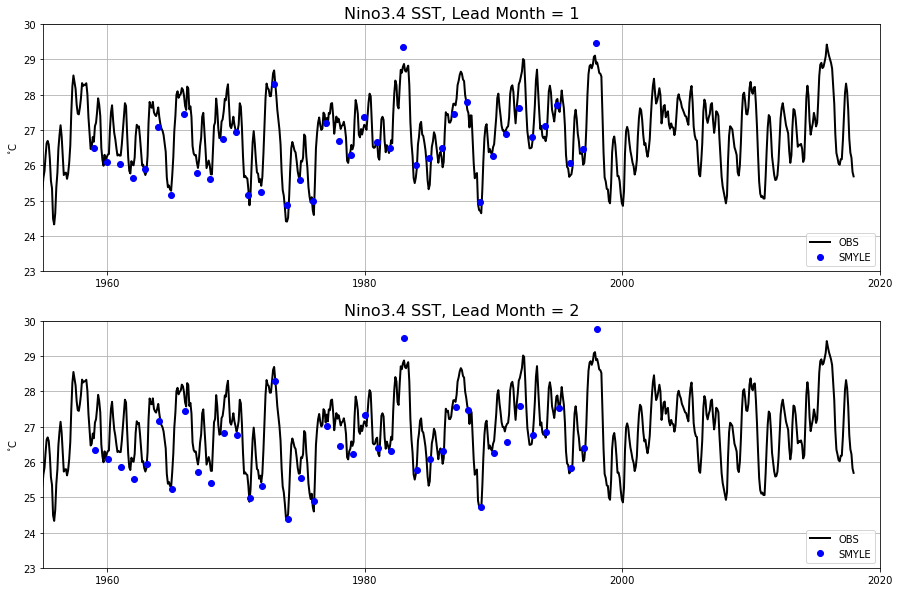

In [20]:
# Create a figure
fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

#tmon = np.linspace(1958. + 0.5*(1./12), 2019 - 0.5*(1./12), num=61*12)
xticks = [1960,1965,1975,1985,1995,2005,2015]
xmin = cftime.num2date(0, 'days since 1955-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2020-01-01 00:00:00', calendar='noleap')

ax1.set_ylabel(r'$^{\circ}$C')
ax1.set_ylim(23,30)
ax1.set_xlim(xmin,xmax)
#ax1.set_xticks(xticks)
lm = 1
smyletime = time_bound.isel(L=lm).mean('d2')
ax1.set_title('Nino3.4 SST, Lead Month = {}'.format(lm), fontdict={'size':16})
ax1.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
#smyle_range = [smyle_nino34.sel(L=lm).min('M'),smyle_nino34.sel(L=lm).max('M')]
#ax1.errorbar(smyletime,smyle_nino34.sel(L=lm).mean('M'),yerr=smyle_range,fmt='o',color='b',label='SMYLE')
ax1.plot(smyletime,smyle_nino34.sel(L=lm).mean('M'),'o',color='b',label='SMYLE')
ax1.grid()
ax1.legend(loc='lower right')

ax2.set_ylabel(r'$^{\circ}$C')
ax2.set_ylim(23,30)
ax2.set_xlim(xmin,xmax)
#ax1.set_xticks(xticks)
lm = 2
smyletime = time_bound.isel(L=lm).mean('d2')
ax2.set_title('Nino3.4 SST, Lead Month = {}'.format(lm), fontdict={'size':16})
ax2.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
#smyle_range = [smyle_nino34.sel(L=lm).min('M'),smyle_nino34.sel(L=lm).max('M')]
#ax2.errorbar(smyletime,smyle_nino34.sel(L=lm).mean('M'),yerr=smyle_range,fmt='o',color='b',label='SMYLE')
ax2.plot(smyletime,smyle_nino34.sel(L=lm).mean('M'),'o',color='b',label='SMYLE')
ax2.grid()
ax2.legend(loc='lower right')
